In [37]:
import numpy as np
import wfdb
from scipy.fft import fft, ifft
import os

# Function to extract heartbeats from the ECG signal
def extract_heartbeats(ecg_signal, r_peaks, annotations, window_size=256):
    heartbeats = []
    labels = []
    for r in r_peaks:
        start = r - window_size // 2
        end = r + window_size // 2
        if start >= 0 and end < len(ecg_signal):
            heartbeat = ecg_signal[start:end]
            heartbeats.append(heartbeat)
            
            # Determine label based on annotation type
            annotation_type = annotations.symbol[np.where(annotations.sample == r)[0][0]]
            if annotation_type in ['N', 'L', 'R', 'A']:  # Normal beats
                labels.append(int(1))
            else:  # Abnormal beats
                labels.append(int(0))
    return heartbeats, labels

# Function to interpolate heartbeats using zero-padding and DFT
def interpolate_heartbeats(heartbeats, target_length=140):
    interpolated_heartbeats = []
    for heartbeat in heartbeats:
        # Zero-padding to the target length
        padded_heartbeat = np.pad(heartbeat, (0, max(0, target_length - len(heartbeat))), 'constant')
        
        # Apply DFT and then IDFT
        transformed = fft(padded_heartbeat)
        interpolated = ifft(transformed).real
        
        # Truncate or pad to ensure uniform length of 140
        if len(interpolated) > target_length:
            interpolated = interpolated[:target_length]
        else:
            interpolated = np.pad(interpolated, (0, target_length - len(interpolated)), 'constant')
        
        interpolated_heartbeats.append(interpolated)
    
    return np.array(interpolated_heartbeats)

# Function to scale data points between -7 and 7
def scale_data(data, min_value=-7, max_value=7):
    data_min = np.min(data)
    data_max = np.max(data)
    
    # Scale data between min_value and max_value
    scaled_data = min_value + (data - data_min) * (max_value - min_value) / (data_max - data_min)
    
    return scaled_data

# Function to process all records in the MIT-BIH Arrhythmia Database
def process_mitbih_database(database_path='./mitdb'):
    # List all record files in the specified directory
    record_files = [f for f in os.listdir(database_path) if f.endswith('.dat')]
    
    all_interpolated_heartbeats = []
    all_labels = []
    
    for record_file in record_files:
        # Extract record name without extension
        record_name = record_file.split('.')[0]
        
        # Load ECG data and annotations
        record = wfdb.rdrecord(os.path.join(database_path, record_name))
        ecg_signal = record.p_signal.flatten()
        annotations = wfdb.rdann(os.path.join(database_path, record_name), 'atr')
        
        # Extract R-peaks from annotations
        r_peaks = annotations.sample
        
        # Extract heartbeats around R-peaks with labels
        heartbeats, labels = extract_heartbeats(ecg_signal, r_peaks, annotations)
        
        # Interpolate heartbeats to a uniform length of 140 points
        interpolated_heartbeats = interpolate_heartbeats(heartbeats)
        
        # Scale each heartbeat to be between -7 and 7
        scaled_heartbeats = scale_data(interpolated_heartbeats)
        
        # Store results for this record
        all_interpolated_heartbeats.extend(scaled_heartbeats)
        all_labels.extend(labels)
    
    return np.array(all_interpolated_heartbeats), np.array(all_labels)

# Save processed data to a file with labels included and serial numbers
def save_processed_data(data, labels, filename='interpolated_ecg_with_labels.csv'):
    combined_data = np.column_stack((data, labels))  # Combine data and labels along columns
    
    # Create serial numbers for each row
    serial_numbers = np.arange(1, combined_data.shape[0] + 1).reshape(-1, 1)
    
    # Combine serial numbers with the data and labels
    final_data = np.hstack((serial_numbers, combined_data))
    
    # Create column names: timestamp_1, timestamp_2, ..., timestamp_N for heartbeat data and label column
    num_timestamps = final_data.shape[1] - 2  # Exclude the label and serial column for naming timestamps
    column_names = ['Serial']+[f'timestamp_{i+1}' for i in range(num_timestamps)] + ['Label']
    
    # Save to CSV with headers and prevent scientific notation using fmt argument
    np.savetxt(filename, final_data, delimiter=',', header=','.join(column_names), comments='', fmt='%s')

# Example usage: specify your local path to the MIT-BIH database files
interpolated_data, labels = process_mitbih_database('./mitdb')

# Save the interpolated data with labels to a file including serial numbers
save_processed_data(interpolated_data, labels)

# Output shape of the final interpolated data array and labels array
print("Total Interpolated Heartbeats Shape:", interpolated_data.shape)
print("Total Labels Shape:", labels.shape)


Total Interpolated Heartbeats Shape: (112580, 140)
Total Labels Shape: (112580,)


In [38]:
import numpy as np
import pandas as pd

# Function to create datasets from the processed ECG data
def create_datasets(data_file='interpolated_ecg_with_labels.csv'):
    # Load the data from the CSV file
    data = pd.read_csv(data_file)
    
    # Convert labels to integers and rename the column
    data.rename(columns={'Serial': ''}, inplace=True)
    data['label'] = data['Label'].astype(int)
    data.drop(columns=['Label'], inplace=True)  # Drop the old 'Label' column

    # Separate normal (label 1) and abnormal (label 0) heartbeats
    normal_data = data[data['label'] == 1]
    abnormal_data = data[data['label'] == 0]

    # Randomly sample from normal data for training dataset (only normal)
    train_dataset = normal_data.sample(n=500, random_state=42)

    # Randomly sample from normal data for validation dataset
    val_normal = normal_data.drop(train_dataset.index).sample(n=250, random_state=42)

    # Randomly sample for test dataset (125 samples each from normal and abnormal)
    test_normal = normal_data.drop(train_dataset.index).drop(val_normal.index).sample(n=125, random_state=42)
    test_abnormal = abnormal_data.sample(n=125, random_state=42)
    test_dataset = pd.concat([test_normal, test_abnormal]).sample(frac=1, random_state=42)  # Shuffle

    # Save datasets to CSV files
    train_dataset.to_csv('./data_preprocessed/train_dataset.csv', index=False)
    val_normal.to_csv('./data_preprocessed/val_dataset.csv', index=False)
    test_dataset.to_csv('./data_preprocessed/test_dataset.csv', index=False)

    print("Datasets created successfully:")
    print(f"Train dataset shape: {train_dataset.shape}")
    print(f"Validation dataset shape: {val_normal.shape}")
    print(f"Test dataset shape: {test_dataset.shape}")

# Example usage: create datasets from the processed ECG data file
create_datasets('interpolated_ecg_with_labels.csv')


Datasets created successfully:
Train dataset shape: (500, 142)
Validation dataset shape: (250, 142)
Test dataset shape: (250, 142)


In [39]:
import pandas as pd
import numpy as np

In [40]:
df = pd.read_csv('interpolated_ecg_with_labels.csv')
df.head().T

,0,1,2,3,4
Serial,1.000000,2.000000,3.000000,4.000000,5.000000
timestamp_1,-1.855908,0.988473,-3.792507,-1.351585,-3.046110
timestamp_2,2.198847,-0.887608,1.351585,-0.806916,-0.463977
timestamp_3,-1.734870,0.927954,-3.832853,-1.351585,-2.824207
timestamp_4,2.057637,-0.907781,1.311239,-0.806916,-1.008646
...,...,...,...,...,...
timestamp_137,1.855908,0.282421,0.322767,-2.804035,-0.322767
timestamp_138,-2.340058,-2.138329,-3.086455,-0.887608,-3.953890
timestamp_139,1.835735,0.221902,0.282421,-2.804035,-0.645533
timestamp_140,-2.340058,-2.219020,-3.126801,-0.887608,-3.792507


In [41]:
df.drop(columns=['Serial'], inplace=True)

In [42]:
df.describe()

,timestamp_1,timestamp_2,timestamp_3,timestamp_4,timestamp_5,timestamp_6,timestamp_7,timestamp_8,timestamp_9,timestamp_10,...,timestamp_132,timestamp_133,timestamp_134,timestamp_135,timestamp_136,timestamp_137,timestamp_138,timestamp_139,timestamp_140,Label
count,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000,...,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000,112580.000000
mean,-0.681560,-0.679067,-0.680705,-0.677701,-0.680037,-0.676609,-0.679281,-0.675853,-0.679095,-0.675523,...,-0.686755,-0.683571,-0.686400,-0.684649,-0.686243,-0.685559,-0.686467,-0.686461,-0.687013,0.825324
std,1.493085,1.489408,1.492153,1.489437,1.491404,1.490072,1.490962,1.491150,1.490649,1.492449,...,1.498409,1.498724,1.498683,1.498101,1.499140,1.497882,1.499612,1.497451,1.499508,0.379691
min,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,...,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,-7.000000,0.000000
25%,-1.605644,-1.593496,-1.604878,-1.591850,-1.607182,-1.590909,-1.607182,-1.591948,-1.604878,-1.592194,...,-1.609705,-1.606462,-1.607843,-1.607978,-1.608315,-1.607407,-1.611036,-1.608315,-1.612121,1.000000
50%,-0.674462,-0.670614,-0.672598,-0.669753,-0.673669,-0.669565,-0.673669,-0.668910,-0.669753,-0.669753,...,-0.682927,-0.676983,-0.682927,-0.678788,-0.682927,-0.679325,-0.683908,-0.679325,-0.682927,1.000000
75%,0.238200,0.242283,0.239316,0.243478,0.242075,0.242283,0.243570,0.243478,0.245427,0.246113,...,0.241379,0.243714,0.243163,0.243163,0.243714,0.245725,0.243478,0.242075,0.242283,1.000000
max,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,...,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,7.000000,1.000000


In [43]:
df.isna().sum()

timestamp_1      0
timestamp_2      0
timestamp_3      0
timestamp_4      0
timestamp_5      0
                ..
timestamp_137    0
timestamp_138    0
timestamp_139    0
timestamp_140    0
Label            0
Length: 141, dtype: int64

In [44]:
df.dtypes

timestamp_1      float64
timestamp_2      float64
timestamp_3      float64
timestamp_4      float64
timestamp_5      float64
                  ...   
timestamp_137    float64
timestamp_138    float64
timestamp_139    float64
timestamp_140    float64
Label            float64
Length: 141, dtype: object

In [45]:
new_columns = list(df.columns)
new_columns[-1] = 'Label'
df.columns = new_columns

In [46]:
df.Label.value_counts()

Label
1.0    92915
0.0    19665
Name: count, dtype: int64

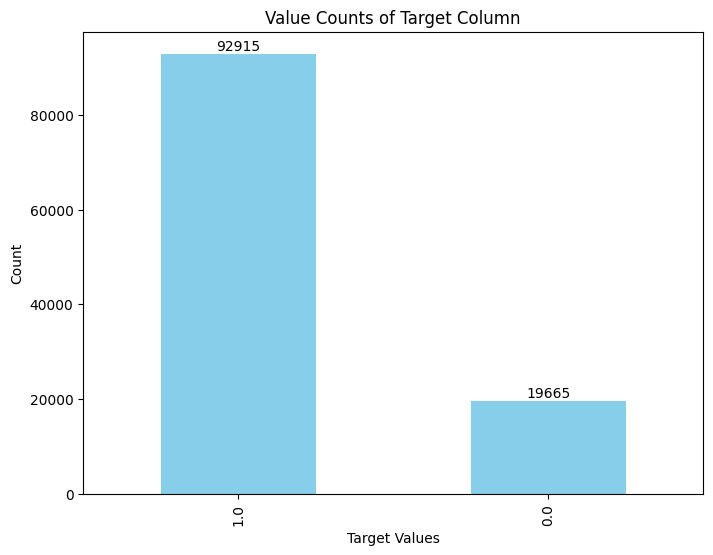

In [47]:
import matplotlib.pyplot as plt
value_counts = df['Label'].value_counts()

plt.figure(figsize=(8, 6))
value_counts.plot(kind='bar', color='skyblue')
plt.title('Value Counts of Target Column')
plt.xlabel('Target Values')
plt.ylabel('Count')

# Display the count values on top of the bars
for i, count in enumerate(value_counts):
    plt.text(i, count + 0.1, str(count), ha='center', va='bottom')

plt.show()

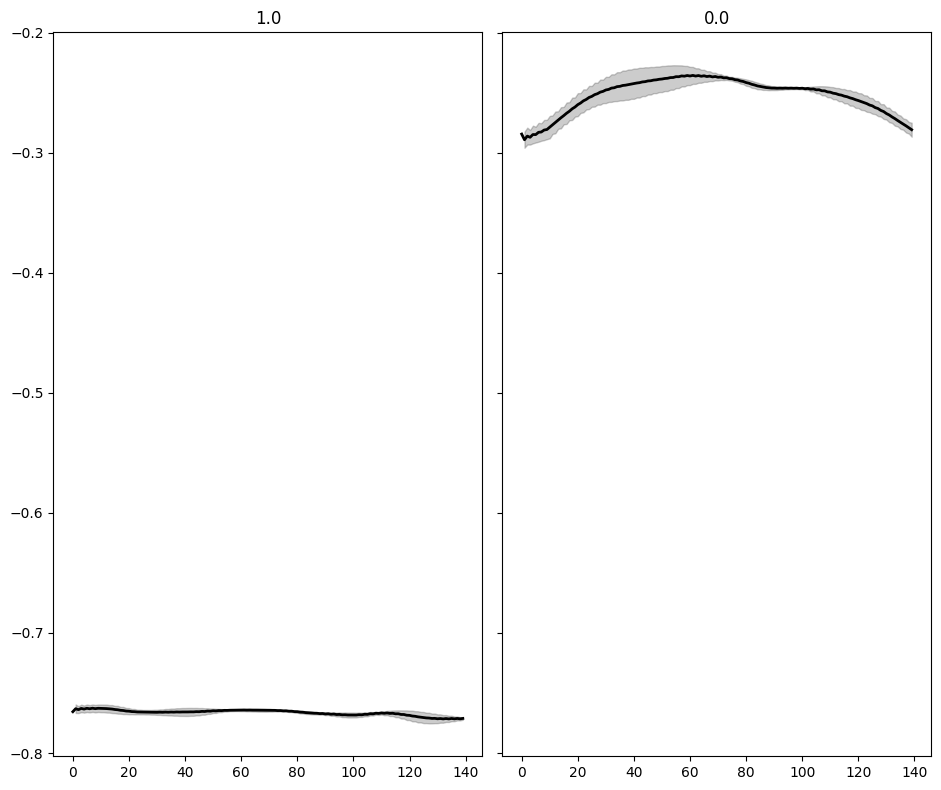

In [48]:
classes = df.Label.unique()

def plot_ecg(data, class_name, ax, n_steps=10):
    time_series_df = pd.DataFrame(data)

    # Apply a moving average for smoothing
    smooth_data = time_series_df.rolling(window=n_steps, min_periods=1).mean()

    # Calculate upper and lower bounds for confidence interval
    deviation = time_series_df.rolling(window=n_steps, min_periods=1).std()
    upper_bound = smooth_data + deviation
    lower_bound = smooth_data - deviation

    # Plot the smoothed data
    ax.plot(smooth_data, color='black', linewidth=2)

    # Plot the confidence interval
    ax.fill_between(time_series_df.index, lower_bound[0], upper_bound[0], color='black', alpha=0.2)

    ax.set_title(class_name)

# Plotting setup
fig, axs = plt.subplots(
    nrows=len(classes) // 3 + 1,
    ncols=3,
    sharey=True,
    figsize=(14, 8)
)

# Plot for each class
for i, cls in enumerate(classes):
    ax = axs.flat[i]
    data = df[df.Label == cls].drop(labels='Label', axis=1).mean(axis=0).to_numpy()
    plot_ecg(data, cls, ax)  # Using 'cls' directly as class name

# Adjust layout and remove extra axes
fig.delaxes(axs.flat[-1])
fig.tight_layout()

plt.show()